In [67]:
from datetime import datetime
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display

pd.set_option('display.max_colwidth', 0)

In [31]:
# Get outward codes
fp = f'../data/misc/london-outward-codes.csv'
outward_codes = pd.read_csv(fp)

outward_codes.head(2)

,outward_code,district_name
0,E1,Head district
1,E2,Bethnal Green


In [32]:
yyyymm = datetime.now().strftime('%Y%m')
fp = f'../data/onthemarket/property_tiles/aggregated/{yyyymm}.csv'
df = pd.read_csv(fp)
df.head(1)

,images-count,price-qualifier,new-home-flag,display_address,cover-images-default,cover-images-webp,floorplans-count,summary,property-labels,property-title,...,floorplans?,for-sale?,agent-base-contact-url,agent-contact-url,agent-details-url,agent-development?,agent-display-logo-url,agent-id,agent-name,agent-telephone
0,13.0,Offers in excess of,True,"The Atlas Building, 145 City Road, London, EC1V",https://media.onthemarket.com/properties/8415459/1332643598/image-0-480x320.jpg,https://media.onthemarket.com/properties/8415459/1332643598/image-0-480x320.webp,1.0,"A well-presented, 2 bedroom apartment in the Atlas Building, Old Street. EC1","['Online viewing', 'New build']",2 bedroom apartment for sale,...,True,True,/agents/contact/8415459/,/agents/contact/8415459/?form-name=details-contact,/agents/branch/jll-city/,False,https://media.onthemarket.com/agents/companies/547/170331113156299/logo-100x65.png,22221,JLL - City,020 8022 7226


In [33]:
df.iloc[0].T

images-count              13                                                                                
price-qualifier           Offers in excess of                                                               
new-home-flag             True                                                                              
display_address           The Atlas Building, 145 City Road, London, EC1V                                   
cover-images-default      https://media.onthemarket.com/properties/8415459/1332643598/image-0-480x320.jpg   
cover-images-webp         https://media.onthemarket.com/properties/8415459/1332643598/image-0-480x320.webp  
floorplans-count          1                                                                                 
summary                   A well-presented, 2 bedroom apartment in the Atlas Building, Old Street. EC1      
property-labels           ['Online viewing', 'New build']                                                   
property-title     

In [28]:
NUMBERS_MAP = {x:i+1 for i, x in enumerate(['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten'])}
def extract_bedrooms(text: str, numbers_map: dict) -> int:
    r = '''
    (one|two|three|four|five|six|seven|eight|nine|ten|\d+)
    [\s-]?
    bed
    '''
    items = re.findall(r, text, flags=re.VERBOSE | re.IGNORECASE)
    if not items:
        return 0

    bedrooms = items[0]

    if bedrooms in [str(x) for x in range(1, 11)]:
        return int(bedrooms)

    return numbers_map.get(bedrooms.lower(), 0)


OUTWARD_CODES = outward_codes['outward_code'].to_list()
def extract_outward_code(text, outward_codes):
    text = text if text else ''
    
    found_codes = []
    for outward_code in outward_codes:
        if outward_code in text:
            found_codes.append(outward_code)
            
    no_of_outward_codes = len(found_codes)

    if no_of_outward_codes == 0:
        result = None
    
    elif no_of_outward_codes == 1:
        result = found_codes[0]
        
    else:
        result = max(found_codes, key=len)

    return result

assert extract_outward_code('The Atlas Building, 145 City Road, London, EC1V', OUTWARD_CODES) == 'EC1'


def extract_price(text) -> int:
    text = text.replace(',', '').replace('£', '')
    if text and text != 'nan':
        return int(text)
    return 0



In [41]:
# Create clean dataframe

clean_df = df.copy()

clean_df['outward_code'] = clean_df['display_address'].apply(lambda x: extract_outward_code(x, OUTWARD_CODES))
clean_df['bedrooms'] = clean_df['summary'].apply(lambda x: extract_bedrooms(x, NUMBERS_MAP))
clean_df['price_extracted'] = clean_df['price'].astype(str).apply(lambda x: extract_price(x))

# Filter

clean_df = clean_df[clean_df['price_extracted'] != 0]
clean_df = clean_df[clean_df['bedrooms'] != 0]

clean_df.shape

(1812, 27)

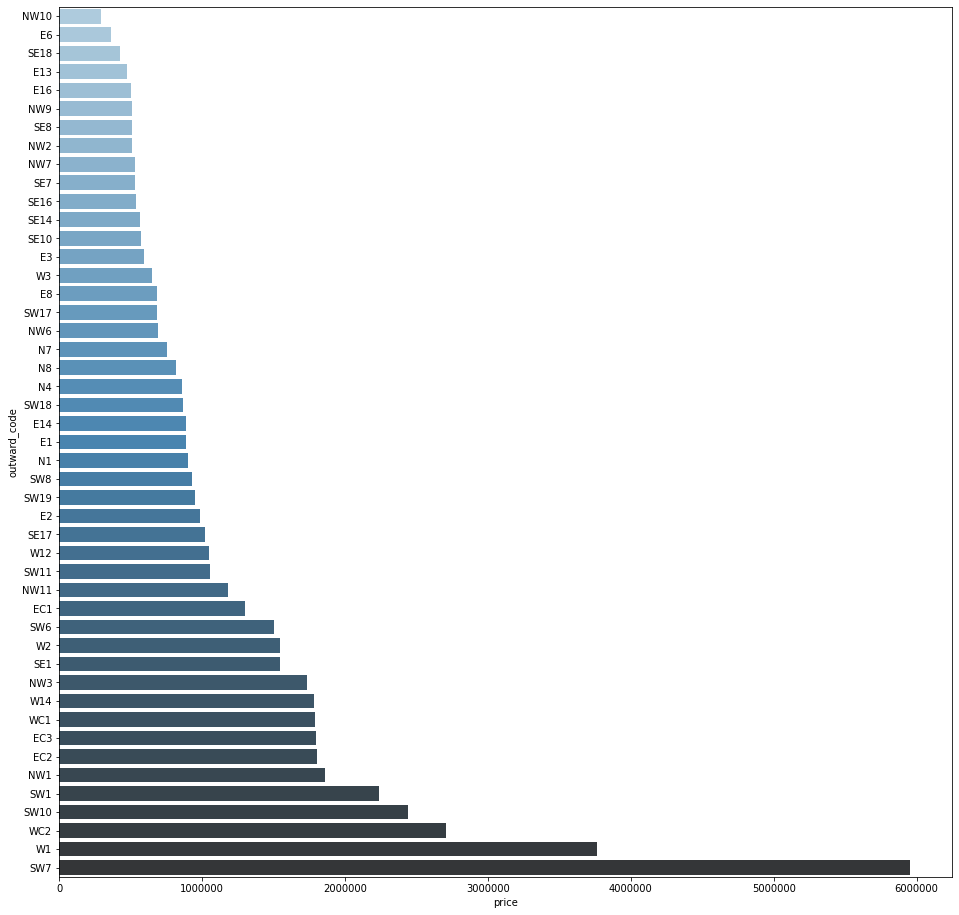

In [94]:
tmp = (
    clean_df
    .groupby(['outward_code', 'bedrooms']).agg(
        price=pd.NamedAgg('price_extracted', 'mean')
    )
    .reset_index()
    .sort_values(by='price')
)

beds_2 = tmp.loc[tmp['bedrooms'] == 2, ['outward_code', 'price']]

_, axis = plt.subplots(1, 1, figsize=(16, 16))

sns.barplot(y=beds_2['outward_code'], x=beds_2['price'], orient='horizonal', ax=axis, palette="Blues_d")
plt.ticklabel_format(style='plain', axis='x')

plt.show()

# display(tmp)